# [Time Series Prediction With Deep Learning in Keras](https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/)

> by **Jason Brownlee** on July 19, 2016 in [Deep Learning](https://machinelearningmastery.com/category/deep-learning/)

Time Series prediction is a difficult problem both to frame and to address with machine learning.

In this post, you will discover how to develop neural network models for time series prediction in Python using the Keras deep learning library.

After reading this post you will know:

- About the airline passengers univariate time series prediction problem.
- How to phrase time series prediction as a regression problem and develop a neural network model for it.
- How to frame time series prediction with a time lag and develop a neural network model for it.

Let’s get started.

- Update Oct/2016: Replaced graphs with more accurate versions, commented on the limited performance of the first method.
- Update Mar/2017: Updated example for Keras 2.0.2, TensorFlow 1.0.1 and Theano 0.9.0.

## Problem Description

The problem we are going to look at in this post is the international airline passengers prediction problem.

This is a problem where given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960 or 12 years, with 144 observations.

The dataset is available for free from the [DataMarket webpage as a CSV download](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) with the filename “international-airline-passengers.csv“.

Below is a sample of the first few lines of the file.

`
"Month","International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
`

We can load this dataset easily using the Pandas library. We are not interested in the date, given that each observation is separated by the same interval of one month. Therefore when we load the dataset we can exclude the first column.

The downloaded dataset also has footer information that we can exclude with the **skipfooter** argument to **pandas.read_csv()** set to 3 for the 3 footer lines. Once loaded we can easily plot the whole dataset. The code to load and plot the dataset is listed below.

In [1]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('../datasets/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

You can see an upward trend in the plot.

You can also see some periodicity to the dataset that probably corresponds to the northern hemisphere summer holiday period.

We are going to keep things simple and work with the data as-is.

Normally, it is a good idea to investigate various data preparation techniques to rescale the data and to make it stationary.

## Multilayer Perceptron Regression

We want to phrase the time series prediction problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month.

We can write a simple function to convert our single column of data into a two-column dataset. The first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

Before we get started, let’s first import all of the functions and classes we intend to use. This assumes a working SciPy environment with the Keras deep learning library installed.

In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Before we do anything, it is a good idea to fix the random number seed to ensure our results are reproducible.

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

We can also use the code from the previous section to load the dataset as a Pandas dataframe. We can then extract the NumPy array from the dataframe and convert the integer values to floating point values which are more suitable for modeling with a neural network.

In [4]:
# load the dataset
dataframe = pandas.read_csv('../datasets/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem we would do this using cross validation.

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Now we can define a function to create a new dataset as described above. The function takes two arguments, the dataset which is a NumPy array that we want to convert into a dataset and the **look_back** which is the number of previous time steps to use as input variables to predict the next time period, in this case, defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured and we will look at constructing a differently shaped dataset in the next section.

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Let’s take a look at the effect of this function on the first few rows of the dataset.

`
X		Y
112		118
118		132
132		129
129		121
121		135
`

If you compare these first 5 rows to the original dataset sample listed in the previous section, you can see the X=t and Y=t+1 pattern in the numbers.

Let’s use this function to prepare the train and test datasets ready for modeling.

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

We can now fit a Multilayer Perceptron model to the training data.

We use a simple network with 1 input, 1 hidden layer with 8 neurons and an output layer. The model is fit using mean squared error, which if we take the square root gives us an error score in the units of the dataset.

I tried a few rough parameters and settled on the configuration below, but by no means is the network listed  optimized.

In [8]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 0s - loss: 47503.9728
Epoch 2/200
 - 0s - loss: 41604.3572
Epoch 3/200
 - 0s - loss: 35660.8113
Epoch 4/200
 - 0s - loss: 29463.1674
Epoch 5/200
 - 0s - loss: 23386.9279
Epoch 6/200
 - 0s - loss: 17696.0768
Epoch 7/200
 - 0s - loss: 12756.7054
Epoch 8/200
 - 0s - loss: 8666.0197
Epoch 9/200
 - 0s - loss: 5575.8750
Epoch 10/200
 - 0s - loss: 3426.3457
Epoch 11/200
 - 0s - loss: 2063.1281
Epoch 12/200
 - 0s - loss: 1287.2954
Epoch 13/200
 - 0s - loss: 865.8692
Epoch 14/200
 - 0s - loss: 674.4337
Epoch 15/200
 - 0s - loss: 584.9193
Epoch 16/200
 - 0s - loss: 555.0298
Epoch 17/200
 - 0s - loss: 546.6795
Epoch 18/200
 - 0s - loss: 547.3851
Epoch 19/200
 - 0s - loss: 538.8329
Epoch 20/200
 - 0s - loss: 538.5323
Epoch 21/200
 - 0s - loss: 536.9798
Epoch 22/200
 - 0s - loss: 536.0266
Epoch 23/200
 - 0s - loss: 537.1224
Epoch 24/200
 - 0s - loss: 535.7814
Epoch 25/200
 - 0s - loss: 538.2078
Epoch 26/200
 - 0s - loss: 538.4700
Epoch 27/200
 - 0s - loss: 538.2272
Epoch 28/200
 - 0s

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

In [9]:
# Estimate model performance
import math
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 531.71 MSE (23.06 RMSE)
Test Score: 2355.06 MSE (48.53 RMSE)


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they aline on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the train dataset in green the predictions on the unseen test dataset in red.

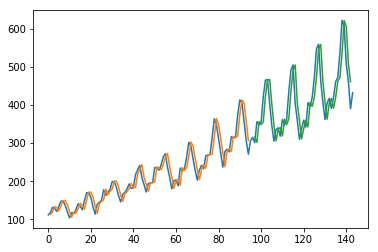

In [10]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Naive Time Series Predictions With Neural Network

Blue=Whole Dataset, Green=Training, Red=Predictions

We can see that the model did a pretty poor job of fitting both the training and the test datasets. It basically predicted the same input value as the output.

For completeness, below is the entire code listing.

96 48
Epoch 1/200
 - 0s - loss: 47508.0731
Epoch 2/200
 - 0s - loss: 41612.8418
Epoch 3/200
 - 0s - loss: 35668.4205
Epoch 4/200
 - 0s - loss: 29468.8867
Epoch 5/200
 - 0s - loss: 23393.4900
Epoch 6/200
 - 0s - loss: 17701.7448
Epoch 7/200
 - 0s - loss: 12760.9084
Epoch 8/200
 - 0s - loss: 8669.5627
Epoch 9/200
 - 0s - loss: 5578.3799
Epoch 10/200
 - 0s - loss: 3428.1792
Epoch 11/200
 - 0s - loss: 2064.1914
Epoch 12/200
 - 0s - loss: 1287.8584
Epoch 13/200
 - 0s - loss: 866.1434
Epoch 14/200
 - 0s - loss: 674.5571
Epoch 15/200
 - 0s - loss: 584.9677
Epoch 16/200
 - 0s - loss: 555.0501
Epoch 17/200
 - 0s - loss: 546.6840
Epoch 18/200
 - 0s - loss: 547.3874
Epoch 19/200
 - 0s - loss: 538.8338
Epoch 20/200
 - 0s - loss: 538.5324
Epoch 21/200
 - 0s - loss: 536.9799
Epoch 22/200
 - 0s - loss: 536.0264
Epoch 23/200
 - 0s - loss: 537.1222
Epoch 24/200
 - 0s - loss: 535.7815
Epoch 25/200
 - 0s - loss: 538.2081
Epoch 26/200
 - 0s - loss: 538.4701
Epoch 27/200
 - 0s - loss: 538.2271
Epoch 28/200

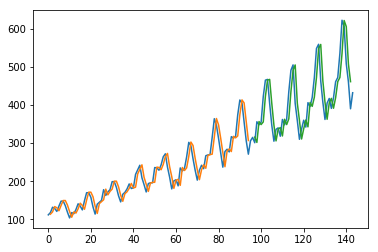

In [11]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t)
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('../datasets/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Taking the square root of the performance estimates, we can see that the model has an average error of 23 passengers (in thousands) on the training dataset and 48 passengers (in thousands) on the test dataset.

## Multilayer Perceptron Using the Window Method

We can also phrase the problem so that multiple recent time steps can be used to make the prediction for the next time step.

This is called the window method, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t + 1), we can use the current time (t) as well as the two prior times (t-1 and t-2).

When phrased as a regression problem the input variables are t-2, t-1, t and the output variable is t+1.

The **create_dataset()** function we wrote in the previous section allows us to create this formulation of the time series problem by increasing the **look_back** argument from 1 to 3.

A sample of the dataset with this formulation looks as follows:

`
X1	X2	X3	Y
112	118	132	129
118	132	129	121
132	129	121	135
129	121	135	148
121	135	148	148
`

We can re-run the example in the previous section with the larger window size. We will increase the network capacity to handle the additional information. The first hidden layer is increased to 14 neurons and a second hidden layer is added with 8 neurons. The number of epochs is also increased to 400.

The whole code listing with just the window size change is listed below for completeness.

Epoch 1/400
 - 0s - loss: 55872.2498
Epoch 2/400
 - 0s - loss: 35430.5373
Epoch 3/400
 - 0s - loss: 22860.0549
Epoch 4/400
 - 0s - loss: 12205.0895
Epoch 5/400
 - 0s - loss: 5346.8866
Epoch 6/400
 - 0s - loss: 2155.5376
Epoch 7/400
 - 0s - loss: 1239.7858
Epoch 8/400
 - 0s - loss: 1095.0938
Epoch 9/400
 - 0s - loss: 1072.3693
Epoch 10/400
 - 0s - loss: 1063.0972
Epoch 11/400
 - 0s - loss: 1049.3822
Epoch 12/400
 - 0s - loss: 1057.7031
Epoch 13/400
 - 0s - loss: 1052.6589
Epoch 14/400
 - 0s - loss: 1047.2305
Epoch 15/400
 - 0s - loss: 1045.6490
Epoch 16/400
 - 0s - loss: 1037.6510
Epoch 17/400
 - 0s - loss: 1044.8486
Epoch 18/400
 - 0s - loss: 1042.5000
Epoch 19/400
 - 0s - loss: 1078.5565
Epoch 20/400
 - 0s - loss: 1047.3390
Epoch 21/400
 - 0s - loss: 1032.3998
Epoch 22/400
 - 0s - loss: 1047.5860
Epoch 23/400
 - 0s - loss: 1064.0826
Epoch 24/400
 - 0s - loss: 1025.2218
Epoch 25/400
 - 0s - loss: 1021.9957
Epoch 26/400
 - 0s - loss: 1031.9663
Epoch 27/400
 - 0s - loss: 1011.2501
Epoch 

Epoch 225/400
 - 0s - loss: 540.6157
Epoch 226/400
 - 0s - loss: 534.3965
Epoch 227/400
 - 0s - loss: 566.5269
Epoch 228/400
 - 0s - loss: 536.0709
Epoch 229/400
 - 0s - loss: 532.0945
Epoch 230/400
 - 0s - loss: 544.8085
Epoch 231/400
 - 0s - loss: 580.2675
Epoch 232/400
 - 0s - loss: 551.9663
Epoch 233/400
 - 0s - loss: 525.8303
Epoch 234/400
 - 0s - loss: 503.5665
Epoch 235/400
 - 0s - loss: 537.4270
Epoch 236/400
 - 0s - loss: 556.2806
Epoch 237/400
 - 0s - loss: 576.9819
Epoch 238/400
 - 0s - loss: 536.0603
Epoch 239/400
 - 0s - loss: 512.6361
Epoch 240/400
 - 0s - loss: 524.2055
Epoch 241/400
 - 0s - loss: 521.4274
Epoch 242/400
 - 0s - loss: 525.5532
Epoch 243/400
 - 0s - loss: 519.0253
Epoch 244/400
 - 0s - loss: 517.8533
Epoch 245/400
 - 0s - loss: 510.8795
Epoch 246/400
 - 0s - loss: 547.4260
Epoch 247/400
 - 0s - loss: 538.9661
Epoch 248/400
 - 0s - loss: 532.2812
Epoch 249/400
 - 0s - loss: 517.3500
Epoch 250/400
 - 0s - loss: 523.5792
Epoch 251/400
 - 0s - loss: 520.7814
E

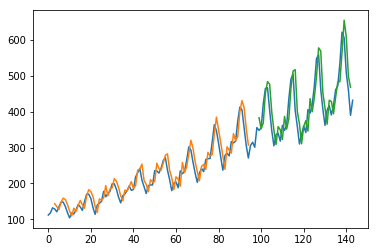

In [12]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t, t-1, t-2)
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('../datasets/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Window Method For Time Series Predictions With Neural Networks

Blue=Whole Dataset, Green=Training, Red=Predictions

We can see that the error was not significantly reduced compared to that of the previous section.

Looking at the graph, we can see more structure in the predictions.

Again, the window size and the network architecture were not tuned, this is just a demonstration of how to frame a prediction problem.

Taking the square root of the performance scores we can see the average error on the training dataset was 23 passengers (in thousands per month) and the average error on the unseen test set was 47 passengers (in thousands per month).

## Summary

In this post, you discovered how to develop a neural network model for a time series prediction problem using the Keras deep learning library.

After working through this tutorial you now know:

- About the international airline passenger prediction time series dataset.
- How to frame time series prediction problems as a regression problems and develop a neural network model.
- How use the window approach to frame a time series prediction problem and develop a neural network model.

Do you have any questions about time series prediction with neural networks or about this post?
Ask your question in the comments below and I will do my best to answer.